# Tests data analysis

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
import os
from matplotlib.ticker import ScalarFormatter

FIGSIZE = (15, 6)

TITLE_FONT = 20
LABEL_FONT = 14
LEGEND_FONT = 12
TICKS_FONT = 11

TITLE_PAD = 16
LABEL_PAD = 12

tight_layout = True

# results are ("Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS")
# Results are gathered from old ChessBot repository and data from tests.ipynb

results_combined = [
    ('PythonChess', 'Python', 'Model', 'TF', 1, 274.56),
    ('PythonChess', 'Python', 'Model', 'TF', 16, 570.88),
    ('PythonChess', 'Python', 'Model', 'TF', 32, 603.8399999999999),
    ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
    ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
    ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
    ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
    ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
    ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56),
    ('RustChess', 'Python', 'Model', 'TF', 1, 385.3),
    ('RustChess', 'Python', 'Model', 'TF', 16, 2398.7),
    ('RustChess', 'Python', 'Model', 'TF', 32, 2926.31),
    ('RustChess', 'Cython', 'Model', 'TF', 1, 474.10999999999996),
    ('RustChess', 'Cython', 'Model', 'TF', 16, 5201.370000000001),
    ('RustChess', 'Cython', 'Model', 'TF', 32, 7992.58),
    ('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
    ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
    ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
    ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
    ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
    ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
    ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
    ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
    ('RustChess', 'Python', 'TRT', 'FP32', 32, 2925.5),
    ('RustChess', 'Cython', 'TRT', 'FP32', 32, 9055.2),
    ('RustChess', 'Python', 'TRT', 'FP16', 32, 3211.5),
    ('RustChess', 'Cython', 'TRT', 'FP16', 32, 13914.4),
]

df = pd.DataFrame(results_combined, columns=[
    "Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS"
])
#df


#### Sideways bar plot of average speed gain

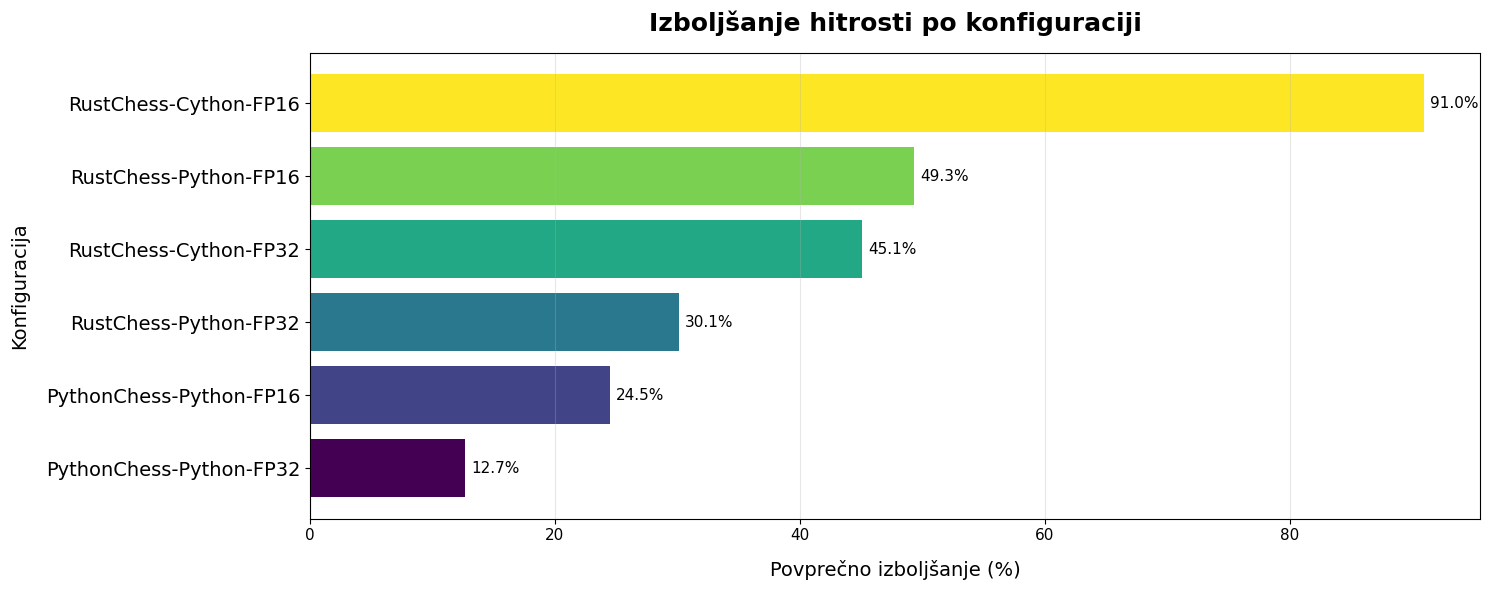

In [2]:
# Create comparison between Model-None and TRT variants
model_data = df[df['ModelType'] == 'Model'].copy()
trt_data = df[df['ModelType'] == 'TRT'].copy()

# Calculate performance improvements
improvements = []
for _, model_row in model_data.iterrows():
    library = model_row['Library']
    language = model_row['Language']
    parallel_reads = model_row['NumParallelReads']
    model_nps = model_row['AvgNPS']
    
    # Find corresponding TRT FP32 performance
    trt_fp32 = trt_data[(trt_data['Library'] == library) & 
                        (trt_data['Language'] == language) & 
                        (trt_data['Precision'] == 'FP32') &
                        (trt_data['NumParallelReads'] == parallel_reads)]
    
    # Find corresponding TRT FP16 performance
    trt_fp16 = trt_data[(trt_data['Library'] == library) & 
                        (trt_data['Language'] == language) & 
                        (trt_data['Precision'] == 'FP16') &
                        (trt_data['NumParallelReads'] == parallel_reads)]
    
    if not trt_fp32.empty:
        fp32_improvement = (trt_fp32['AvgNPS'].iloc[0] / model_nps - 1) * 100
        improvements.append((library, language, parallel_reads, 'FP32', fp32_improvement))
    
    if not trt_fp16.empty:
        fp16_improvement = (trt_fp16['AvgNPS'].iloc[0] / model_nps - 1) * 100
        improvements.append((library, language, parallel_reads, 'FP16', fp16_improvement))

improvement_df = pd.DataFrame(improvements, columns=['Library', 'Language', 'ParallelReads', 'Precision', 'Improvement_%'])


plt.figure(figsize=FIGSIZE)

improvement_df['Config'] = improvement_df['Library'] + '-' + improvement_df['Language'] + '-' + improvement_df['Precision']
config_avg = improvement_df.groupby('Config')['Improvement_%'].mean().sort_values(ascending=True)
bars = plt.barh(range(len(config_avg)), config_avg.values, 
                color=plt.cm.viridis(np.linspace(0, 1, len(config_avg))))

plt.yticks(range(len(config_avg)), config_avg.index, fontsize=LABEL_FONT)
plt.title('Izboljšanje hitrosti po konfiguraciji', fontsize=TITLE_FONT, fontweight='bold', pad=TITLE_PAD)
plt.xlabel('Povprečno izboljšanje (%)', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
plt.ylabel('Konfiguracija', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
plt.xticks(fontsize=TICKS_FONT)

for i, val in enumerate(config_avg.values):
     plt.text(val+0.5, i, f'{val:.1f}%', va='center', fontsize=11)

plt.grid(True, alpha=0.3, axis='x')

if tight_layout:
    plt.tight_layout()
plt.show()


#### Heatmap of performance based on configuration

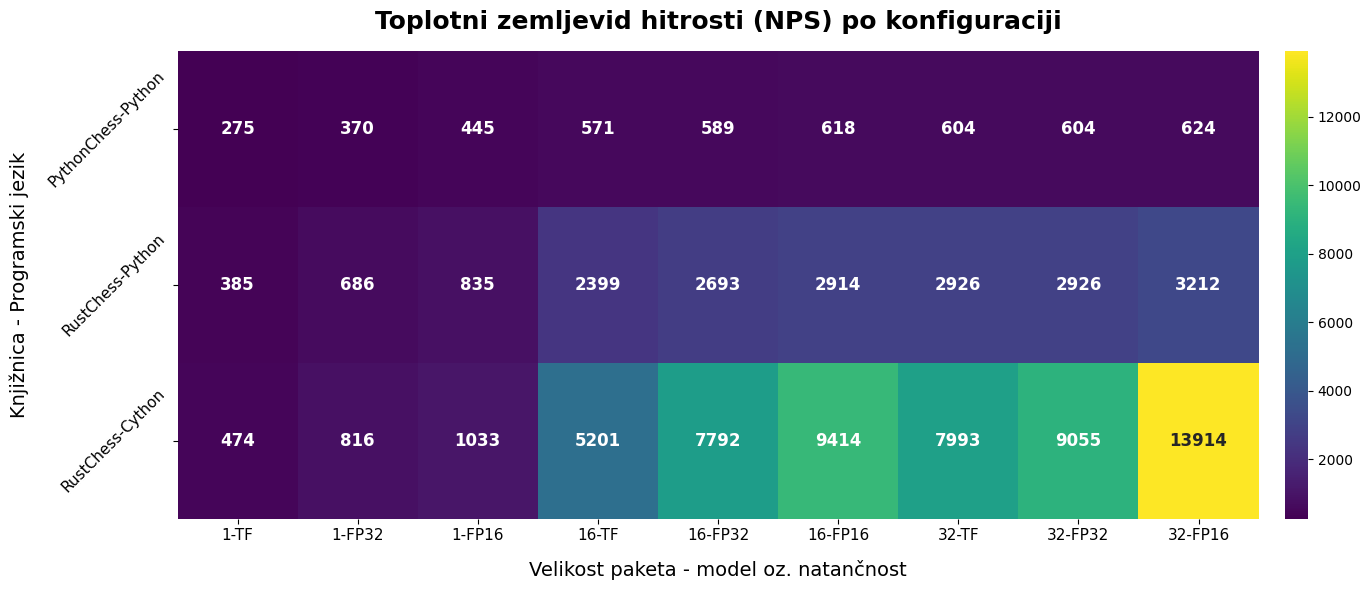

In [3]:
# Create the heatmap using the df variable
plt.figure(figsize=FIGSIZE)


# Create the pivot table for the heatmap
precision_pivot = df.pivot_table(
    index=['Library', 'Language'], 
    columns=['NumParallelReads', 'Precision'], 
    values='AvgNPS'
)

# Define the desired order for the rows
new_order = [
    ('PythonChess', 'Python'),
    ('RustChess', 'Python'),
    ('RustChess', 'Cython')
]

# Reindex the pivot table to match the desired order
precision_pivot = precision_pivot.reindex(new_order)

# Define the desired column order
new_column_order = [
    (1, 'TF'), (1, 'FP32'), (1, 'FP16'),
    (16, 'TF'), (16, 'FP32'), (16, 'FP16'),
    (32, 'TF'), (32, 'FP32'), (32, 'FP16')
]

# Reindex the columns to match the desired order
precision_pivot = precision_pivot[new_column_order]


# Create the heatmap
sns.heatmap(precision_pivot, 
           annot=True, 
           fmt='.0f', 
           cmap='viridis',
           cbar_kws={
            #'label': 'Povprečna hitrost (NPS)', 
            'pad': 0.02},
           annot_kws={"size": 12, "weight": "bold"})

plt.title('Toplotni zemljevid hitrosti (NPS) po konfiguraciji', fontsize=TITLE_FONT, fontweight='bold', pad=TITLE_PAD)
plt.xlabel('Velikost paketa - model oz. natančnost', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
plt.ylabel('Knjižnica - Programski jezik', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
plt.xticks(fontsize=TICKS_FONT)
plt.yticks(rotation=45, fontsize=TICKS_FONT)

# Adjust layout to prevent label cutoff
if tight_layout:
    plt.tight_layout()
plt.show()

#### Bar graph focusing on library comparisson while using TRT models

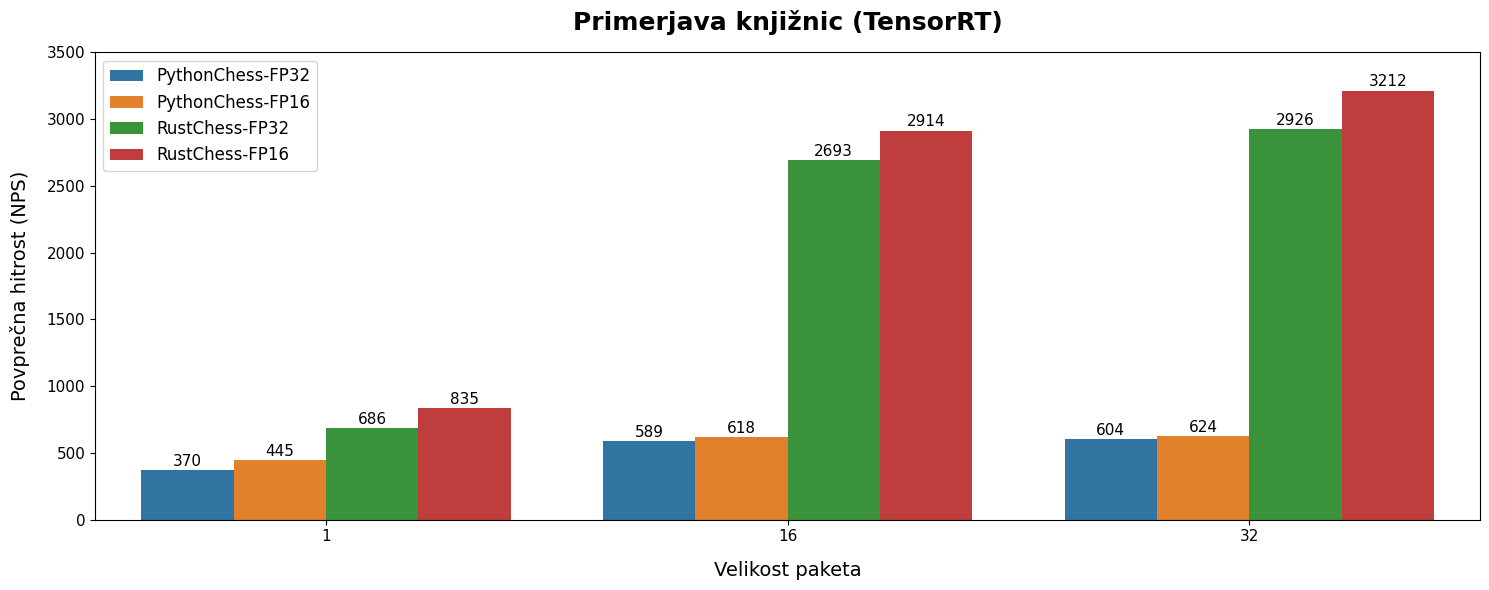

In [4]:
# Create a standalone plot for Library Performance Comparison
plt.figure(figsize=FIGSIZE)

python_trt_data = df[(df['Language'] == 'Python') & (df['ModelType'] == 'TRT')].copy()
python_trt_data['Config'] = python_trt_data['Library'] + '-' + python_trt_data['Precision']

ax = sns.barplot(data=python_trt_data, x='NumParallelReads', y='AvgNPS', hue='Config')

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=11, padding=1)

ax.set_title('Primerjava knjižnic (TensorRT)', fontsize=TITLE_FONT, fontweight='bold', pad=TITLE_PAD)
ax.set_xlabel('Velikost paketa', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax.set_ylabel('Povprečna hitrost (NPS)', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax.legend(prop={'size': LEGEND_FONT})

# Set y-axis ticks in increments of 500
max_nps = python_trt_data['AvgNPS'].max()
ax.set_yticks(np.arange(0, max_nps * 1.1, 500))

plt.xticks(fontsize=TICKS_FONT)
plt.yticks(fontsize=TICKS_FONT)


if tight_layout:
    plt.tight_layout()
plt.show()

#### Bar graph focusing on language comparission while using TRT models and Rust library

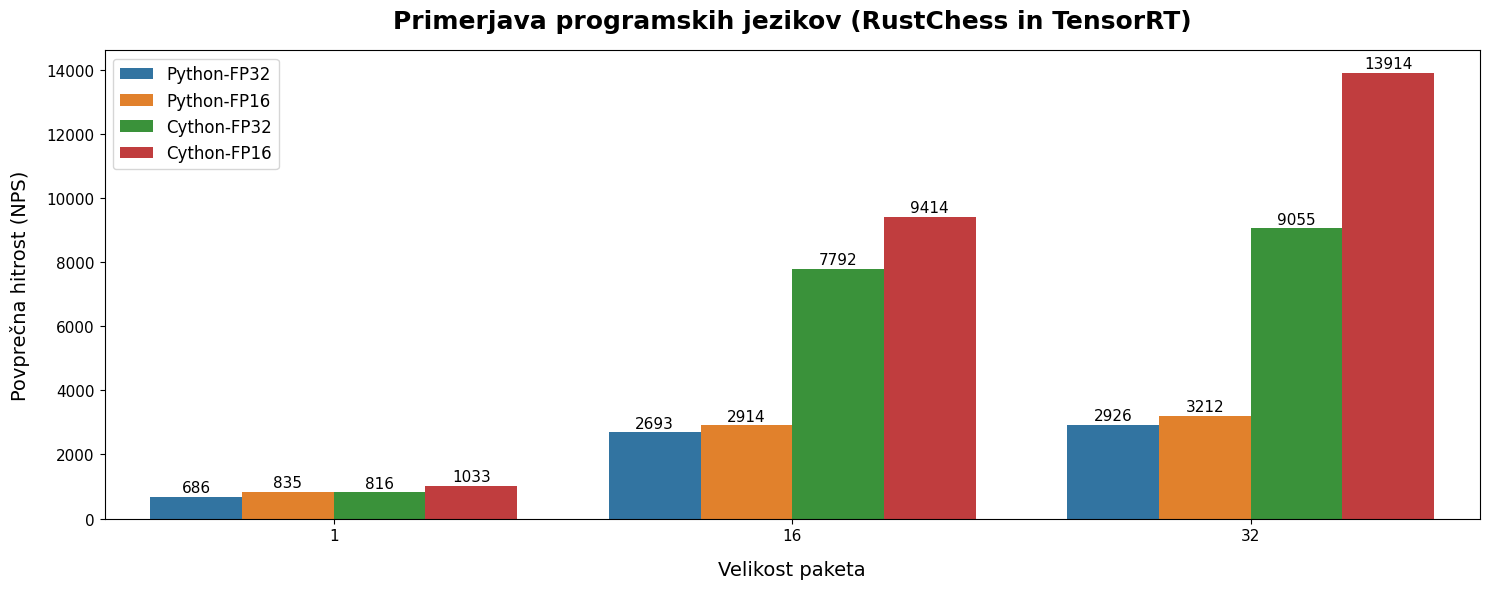

In [5]:
# Create a standalone plot for Language Performance Comparison (RustChess only)
plt.figure(figsize=FIGSIZE)

rust_data = df[(df['Library'] == 'RustChess') & (df['ModelType'] == 'TRT')].copy()

rust_data['Config'] = rust_data['Language'] + '-' + rust_data['Precision']

# Define the desired order for the hue
hue_order = ['Python-FP32', 'Python-FP16', 'Cython-FP32', 'Cython-FP16']

ax2 = sns.barplot(data=rust_data, x='NumParallelReads', y='AvgNPS', hue='Config', hue_order=hue_order)

# Add labels on top of each bar
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', label_type='edge', fontsize=11, padding=1)

ax2.set_title('Primerjava programskih jezikov (RustChess in TensorRT)', fontsize=TITLE_FONT, fontweight='bold', pad=TITLE_PAD)
ax2.set_xlabel('Velikost paketa', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax2.set_ylabel('Povprečna hitrost (NPS)', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax2.legend(prop={'size': LEGEND_FONT})

# Set y-axis ticks in increments of 1000 up to 14000
ax2.set_yticks(np.arange(0, 16000, 2000))

plt.xticks(fontsize=TICKS_FONT)
plt.yticks(fontsize=TICKS_FONT)

if tight_layout:
    plt.tight_layout()
plt.show()

# Perft data analysis

In [6]:
perft_results = [{'Position': 'Initial',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.07952327728271484,
  'Nodes': 8902},
 {'Position': 'Initial',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.004886007308959961,
  'Nodes': 8902},
 {'Position': 'Initial',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 1.5494667530059814,
  'Nodes': 197281},
 {'Position': 'Initial',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 0.10483388900756836,
  'Nodes': 197281},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.7435322761535644,
  'Nodes': 97862},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.04950494766235351,
  'Nodes': 97862},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 31.774331951141356,
  'Nodes': 4085603},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 2.084269094467163,
  'Nodes': 4085603},
 {'Position': 'Pos 3',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.023418188095092773,
  'Nodes': 2812},
 {'Position': 'Pos 3',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.0015196800231933594,
  'Nodes': 2812},
 {'Position': 'Pos 3',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 0.3737182140350342,
  'Nodes': 43238},
 {'Position': 'Pos 3',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 0.023618364334106447,
  'Nodes': 43238}]
df_perft = pd.DataFrame(perft_results)

# Convert time to milliseconds for better readability also round to 2 decimal places
df_perft['Avg Time (ms)'] = (df_perft['Avg Time (s)'] * 1000).round(1)

df_perft

,Position,Depth,Library,Avg Time (s),Nodes,Avg Time (ms)
0,Initial,3,python-chess,0.079523,8902,79.5
1,Initial,3,rchess,0.004886,8902,4.9
2,Initial,4,python-chess,1.549467,197281,1549.5
3,Initial,4,rchess,0.104834,197281,104.8
4,KiwiPete (Pos 2),3,python-chess,0.743532,97862,743.5
5,KiwiPete (Pos 2),3,rchess,0.049505,97862,49.5
6,KiwiPete (Pos 2),4,python-chess,31.774332,4085603,31774.3
7,KiwiPete (Pos 2),4,rchess,2.084269,4085603,2084.3
8,Pos 3,3,python-chess,0.023418,2812,23.4
9,Pos 3,3,rchess,0.001520,2812,1.5


In [7]:
# Create a pivot table for better visualization
pivot_perft = df_perft.pivot_table(
    index=['Position', 'Depth'],
    columns='Library',
    values='Avg Time (ms)',
    aggfunc='mean'
).reset_index()
pivot_perft

Library,Position,Depth,python-chess,rchess
0,Initial,3,79.5,4.9
1,Initial,4,1549.5,104.8
2,KiwiPete (Pos 2),3,743.5,49.5
3,KiwiPete (Pos 2),4,31774.3,2084.3
4,Pos 3,3,23.4,1.5
5,Pos 3,4,373.7,23.6


# Training data analysis

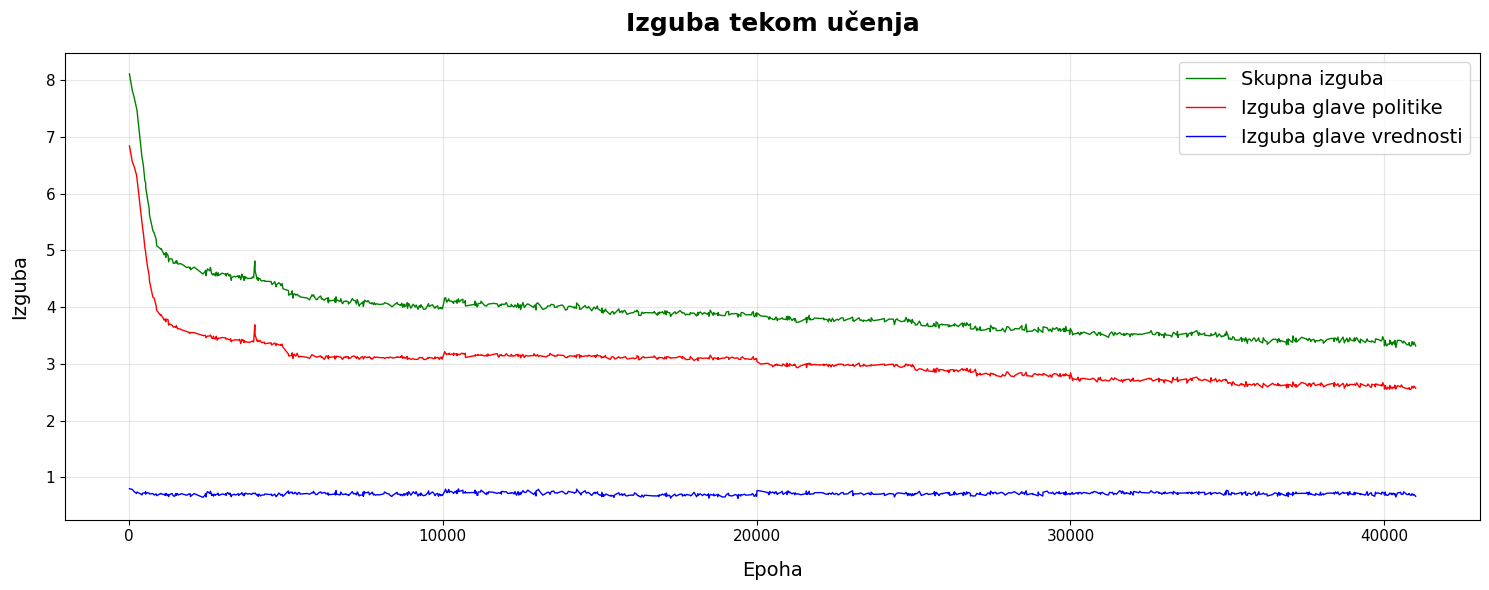

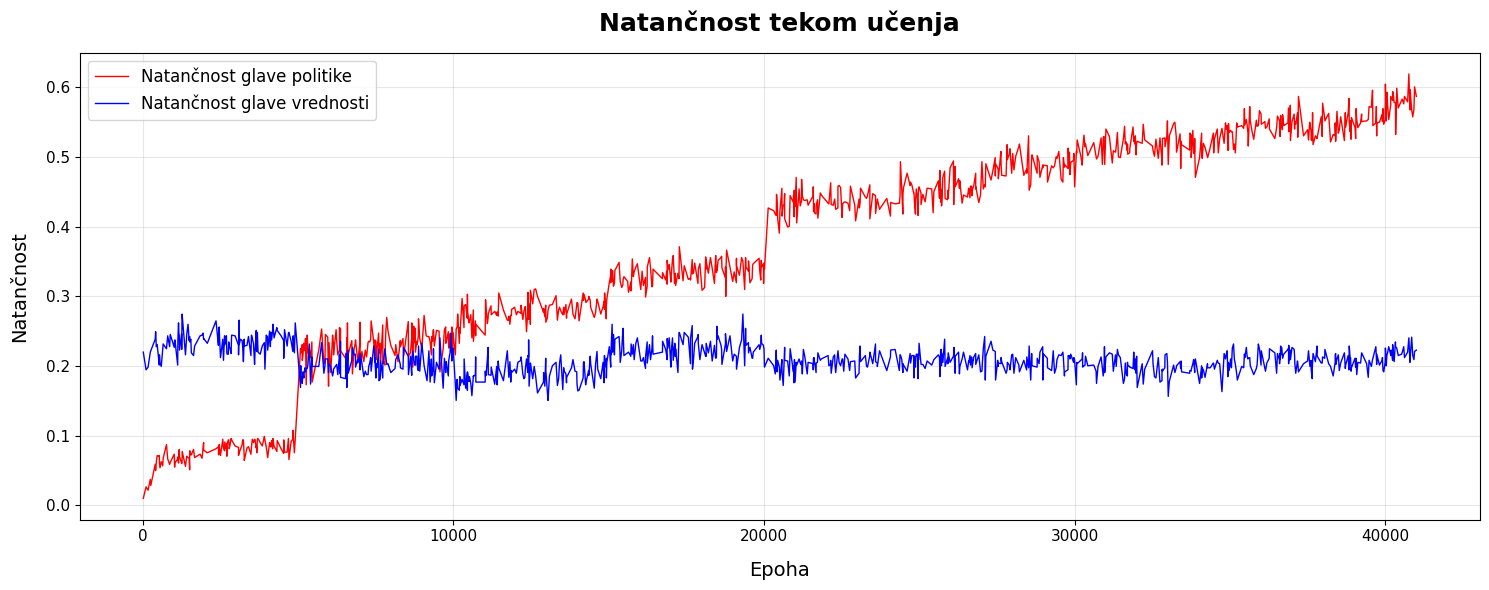

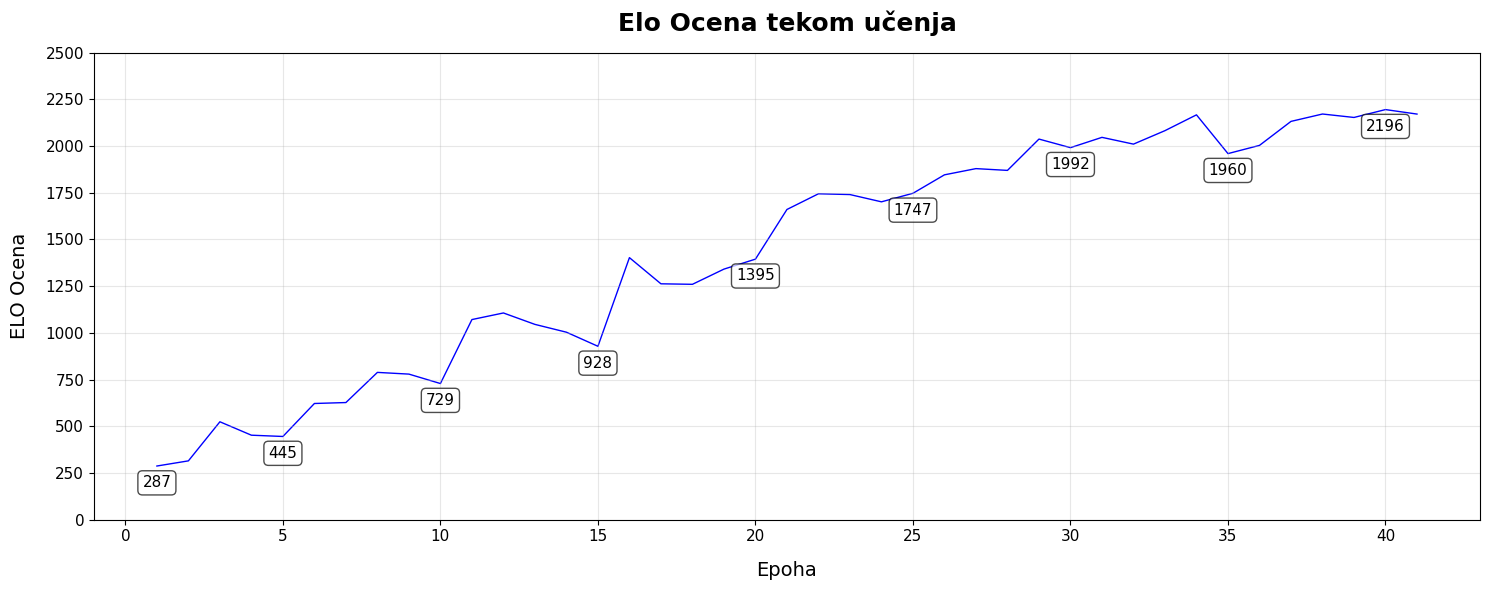

In [8]:
def load_tensorboard_json(filepath):
    """Load TensorBoard JSON log file and return parsed data"""
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        # Extract timestamp, step, and value
        timestamps = [entry[0] for entry in data]
        steps = [entry[1] for entry in data]
        values = [entry[2] for entry in data]
        
        # Convert timestamps to datetime objects
        datetime_objects = [datetime.fromtimestamp(ts) for ts in timestamps]
        
        return {
            'timestamps': timestamps,
            'datetime': datetime_objects,
            'steps': steps,
            'values': values,
            'filename': os.path.basename(filepath)
        }
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

# Configuration for plots
# plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['font.size'] = 10

results_dir = '../results'
json_files = [
    'epoch_loss.json',
    'epoch_policy_head_loss.json',
    'epoch_policy_head_accuracy.json',
    'epoch_value_head_loss.json',
    'epoch_value_head_accuracy.json',
    'ELO Rating.json'
]

# Load all data
metrics_data = {}
for filename in json_files:
    filepath = os.path.join(results_dir, filename)
    if os.path.exists(filepath):
        data = load_tensorboard_json(filepath)
        if data:
            metrics_data[filename] = data

# 1. Combined loss plot
plt.figure(figsize=FIGSIZE)
ax1 = plt.gca()
loss_files = ['epoch_loss.json', 'epoch_policy_head_loss.json', 'epoch_value_head_loss.json']
labels = ['Skupna izguba', 'Izguba glave politike', 'Izguba glave vrednosti']
colors = ['green', 'red', 'blue']

for i, filename in enumerate(loss_files):
    if filename in metrics_data:
        data = metrics_data[filename]
        label = labels[i]
        ax1.plot(data['steps'], data['values'], color=colors[i], label=label, linewidth=1, alpha=1)

ax1.set_title('Izguba tekom učenja', fontweight='bold', fontsize=TITLE_FONT, pad=TITLE_PAD)
ax1.set_xlabel('Epoha', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax1.set_ylabel('Izguba', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax1.legend(prop={'size': LABEL_FONT})
ax1.grid(True, alpha=0.3)

plt.xticks(fontsize=TICKS_FONT)
plt.yticks(fontsize=TICKS_FONT)

if tight_layout:
    plt.tight_layout()
plt.show()

# 2. Combined accuracy plot
plt.figure(figsize=FIGSIZE)
ax2 = plt.gca()
acc_files = ['epoch_policy_head_accuracy.json', 'epoch_value_head_accuracy.json']
labels = ['Natančnost glave politike', 'Natančnost glave vrednosti']
colors = ['red', 'blue']

for i, filename in enumerate(acc_files):
    if filename in metrics_data:
        data = metrics_data[filename]
        label = labels[i]
        ax2.plot(data['steps'], data['values'], color=colors[i], label=label, linewidth=1, alpha=1)

ax2.set_title('Natančnost tekom učenja', fontweight='bold', fontsize=TITLE_FONT, pad=TITLE_PAD)
ax2.set_xlabel('Epoha', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax2.set_ylabel('Natančnost', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax2.legend(prop={'size': LEGEND_FONT})
ax2.grid(True, alpha=0.3)

plt.xticks(fontsize=TICKS_FONT)
plt.yticks(fontsize=TICKS_FONT)

if tight_layout:
    plt.tight_layout()
plt.show()

# 3. ELO Rating evolution
if 'ELO Rating.json' in metrics_data:
    plt.figure(figsize=FIGSIZE)
    ax3 = plt.gca()
    data = metrics_data['ELO Rating.json']
    ax3.plot(data['steps'], data['values'], color='blue', linewidth=1, alpha=1, zorder=1)
    ax3.set_title('Elo Ocena tekom učenja', fontweight='bold', fontsize=TITLE_FONT, pad=TITLE_PAD)
    ax3.set_xlabel('Epoha', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
    ax3.set_ylabel('ELO Ocena', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
    ax3.grid(True, alpha=0.3)
    
    # Set y-axis limits and ticks
    ax3.set_ylim(0, 2500)
    ax3.set_yticks(np.arange(0, 2501, 250))
    
    # Add milestone markers
    steps = np.array(data['steps'])
    values = np.array(data['values'])
    
    # Create a dictionary to map step to value for easy lookup
    step_to_value = dict(zip(steps, values))
    
    # Determine the range of steps to mark
    max_step = steps.max()
    milestone_steps = [s for s in range(0, max_step + 1, 5) if s in step_to_value]
    if 1 in step_to_value and 1 not in milestone_steps:
        milestone_steps.append(1)
        milestone_steps.sort()

    for step in milestone_steps:
        elo = step_to_value[step]
        ax3.plot(step, elo, '', color='gold', markersize=8, zorder=2, markeredgecolor='black')
        ax3.text(step, elo - 50, f'{elo:.0f}', 
                    ha='center', va='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7), zorder=3, fontsize=11)

    plt.xticks(fontsize=TICKS_FONT)
    plt.yticks(fontsize=TICKS_FONT)

    if tight_layout:
        plt.tight_layout()
    plt.show()

In [9]:
strength_data = {
    'Simulations (thousands)': [100_000, 50_000, 25_000, 10_000, 5_000, 2_500, 1_000],
    'ELO': [2737, 2626, 2514, 2327, 2196, 1960, 1547]
}
df_strength = pd.DataFrame(strength_data)
df_strength


,Simulations (thousands),ELO
0,100000,2737
1,50000,2626
2,25000,2514
3,10000,2327
4,5000,2196
5,2500,1960
6,1000,1547


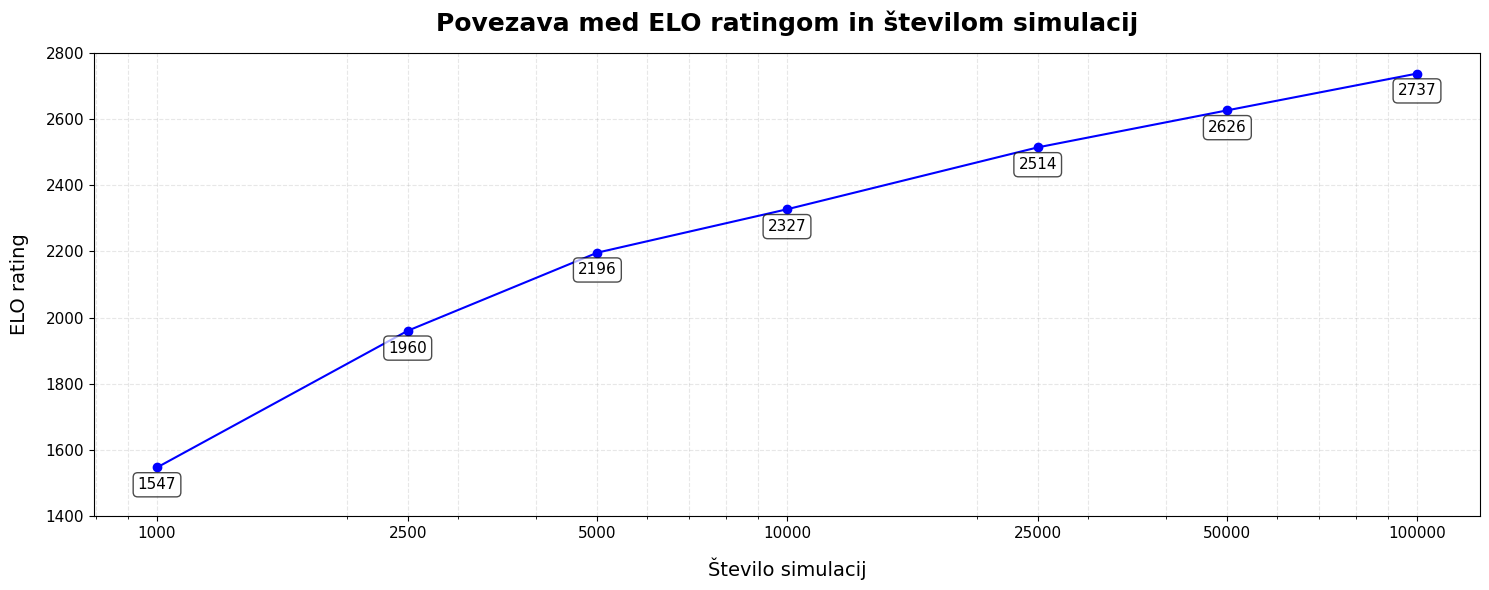

In [10]:
# Sort the dataframe for a proper line plot
df_strength_sorted = df_strength.sort_values('Simulations (thousands)')

# Create the plot
plt.figure(figsize=FIGSIZE)
ax = plt.gca()

# Plot the data
ax.plot(df_strength_sorted['Simulations (thousands)'], df_strength_sorted['ELO'], marker='o', linestyle='-', color='blue', zorder=2)

# Set x-axis to logarithmic scale
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks(df_strength_sorted['Simulations (thousands)'])


# Add titles and labels
ax.set_title('Povezava med ELO ratingom in številom simulacij', fontsize=TITLE_FONT, fontweight='bold', pad=TITLE_PAD)
ax.set_xlabel('Število simulacij', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
ax.set_ylabel('ELO rating', fontsize=LABEL_FONT, labelpad=LABEL_PAD)

# Set y-axis limits
ax.set_ylim(1400, 2800)

# Add data labels
for i, row in df_strength_sorted.iterrows():
    ax.text(row['Simulations (thousands)'], row['ELO'] -75, f"{row['ELO']}", ha='center', va='bottom', fontsize=11,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7), zorder=3)

# Add grid
ax.grid(True, which="both", ls="--", alpha=0.3, zorder=1)

plt.xticks(fontsize=TICKS_FONT)
plt.yticks(fontsize=TICKS_FONT)

# Show plot
if tight_layout:
    plt.tight_layout()
plt.show()

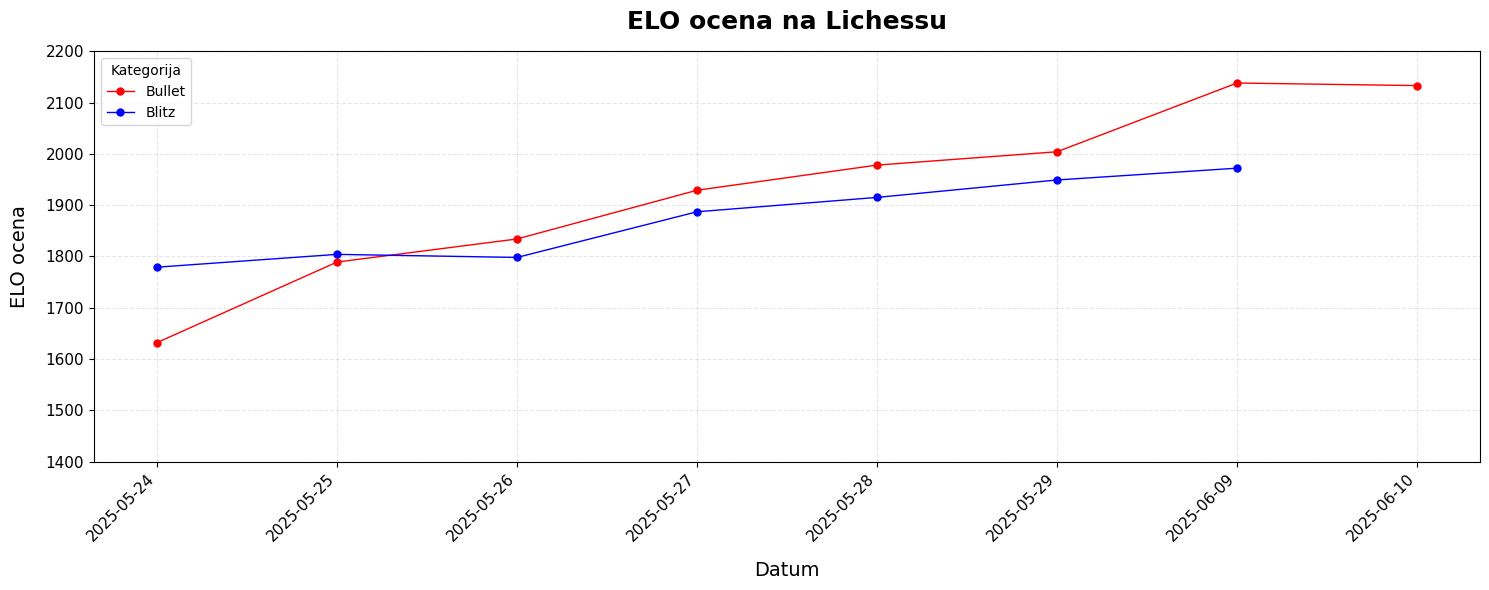

In [11]:
# Load ELO data from lichess
elo_file_path = '../results/lichess/elo.json'
elo_data = []

try:
    with open(elo_file_path, 'r') as f:
        elo_data = json.load(f)
except FileNotFoundError:
    print(f"Error: File not found at {elo_file_path}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {elo_file_path}")
except Exception as e:
    print(f"An error occurred: {e}")


if elo_data:
    # Create a plot for ELO evolution
    plt.figure(figsize=FIGSIZE)
    ax = plt.gca()

    colors = {'bullet': 'red', 'blitz': 'blue'}
    
    all_dates = []
    
    # elo_data is a list of dictionaries, so we iterate through the list
    for item in elo_data:
        game_type = item.get('name')
        data_points = item.get('points')

        if game_type and data_points:
            # Filter for only bullet and blitz games as requested by the color map
            if game_type.lower() in colors:
                # Extract dates and ELO ratings
                # The data format is [year, month(0-indexed), day, rating]
                dates = [datetime(d[0], d[1] + 1, d[2]) for d in data_points]
                elos = [d[3] for d in data_points]
                
                # Use index for x-axis to ensure even spacing
                indices = range(len(dates))
                ax.plot(indices, elos, label=game_type.title(), color=colors.get(game_type.lower(), 'gray'), linewidth=1, marker='o', markersize=5)
                
                if not all_dates:
                    all_dates = dates

    # Add titles and labels
    ax.set_title('ELO ocena na Lichessu', fontsize=TITLE_FONT, fontweight='bold', pad=TITLE_PAD)
    ax.set_xlabel('Datum', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
    ax.set_ylabel('ELO ocena', fontsize=LABEL_FONT, labelpad=LABEL_PAD)
    
    # Add legend and grid
    ax.legend(title='Kategorija')
    ax.grid(True, which="both", ls="--", alpha=0.3)
    
    # Set y-axis limits to provide better context
    ax.set_ylim(1400, 2200)
    
    # Set x-axis ticks and labels for even spacing
    if all_dates:
        ax.set_xticks(range(len(all_dates)))
        ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in all_dates], rotation=45, ha='right')

    plt.xticks(fontsize=TICKS_FONT)
    plt.yticks(fontsize=TICKS_FONT)

    # Show plot
    if tight_layout:
        plt.tight_layout()
    plt.show()
else:
    print("No ELO data to plot.")

#### Length of training calculations

In [12]:
file_path = '../results/epoch_loss.json'
timestamps = []

try:
    with open(file_path, 'r') as f:
        data = json.load(f)
        timestamps = [entry[0] for entry in data]
    print(f"Loaded {len(timestamps)} timestamps.")
    print("First 10 timestamps:", timestamps[:10])
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

if timestamps:
    total_training_time = 0
    pause_threshold = 4 * 60  # 4 minutes in seconds

    # Iterate through consecutive timestamps to calculate active training time
    for i in range(len(timestamps) - 1):
        duration = timestamps[i+1] - timestamps[i]
        if duration <= pause_threshold:
            total_training_time += duration

    # Convert total seconds to a more readable format (hours, minutes, seconds)
    hours = int(total_training_time // 3600)
    minutes = int((total_training_time % 3600) // 60)
    seconds = int(total_training_time % 60)

    print(f"\nTotal active training time (excluding pauses > 4 minutes):")
    print(f"{hours} hours, {minutes} minutes, {seconds} seconds")
else:
    print("No timestamps to analyze.")

Loaded 1000 timestamps.
First 10 timestamps: [1746429526.471072, 1746429552.883163, 1746429571.979557, 1746429592.944287, 1746429597.302673, 1746429639.979941, 1746429643.236183, 1746429650.274161, 1746429658.077217, 1746430098.256299]

Total active training time (excluding pauses > 4 minutes):
2 hours, 44 minutes, 17 seconds


In [13]:
num_tests = 1500
num_agents = 6
time_per_test = 1.0
tests_per_agent = num_tests // num_agents
print(tests_per_agent)
time_for_tests = tests_per_agent * time_per_test

m, s = divmod(time_for_tests, 60)
h, m = divmod(m, 60)
print(f"Time for STS tests: {h} hours, {m} minutes and {s} seconds")

intervals = len([i for i in range(1, 42)])
time_for_all_tests = time_for_tests * intervals
m, s = divmod(time_for_all_tests, 60)
h, m = divmod(m, 60)
print(f"Time for STS tests: {h} hours, {m} minutes and {s} seconds")

250
Time for STS tests: 0.0 hours, 4.0 minutes and 10.0 seconds
Time for STS tests: 2.0 hours, 50.0 minutes and 50.0 seconds


In [14]:
sampled = 41_984_000
unsampled = 76_334_545
ratio = 0.55

original_samples = sampled / ratio
print(f"Original number of samples before sampling: {int(original_samples)}")

Original number of samples before sampling: 76334545


In [15]:
# Estimate time taken to generate all data
def time_per_update(time_s, samples):
    pos_per_update = 5_120_000
    sampling_ratio = 0.55

    total_samples = samples * sampling_ratio

    samples_per_s = total_samples // time_s
    s_per_update = pos_per_update // samples_per_s
    m, s = divmod(s_per_update, 60)
    h, m = divmod(m, 60)

    return s_per_update, f"{h} hours, {m} minutes and {s} seconds"

time0_s, time_str = time_per_update(8 * 60 + 19, 16722)
print(f"Time for first update: {time_str}")
timen_s, time_str = time_per_update(2 * 60 + 27, 5454)
print(f"Time for last update: {time_str}")


Time for first update: 79.0 hours, 0.0 minutes and 44.0 seconds
Time for last update: 71.0 hours, 6.0 minutes and 40.0 seconds


In [16]:
max_s = time0_s
min_s = timen_s
intervals = 7
diff = max_s - min_s
int_diff = diff // intervals

times = [max_s]
for i in range(intervals - 1):
    time = max_s - (i+1)*int_diff
    times.append(time)
times.append(min_s)

full_time = sum(times)
# Convert seconds to hours, minutes and seconds
m, s = divmod(full_time, 60)
h, m = divmod(m, 60)
print(f"Time spent to generate all data: {h} hours, {m} minutes and {s} seconds")

days = h // 24
print(f"Which is roughly: {days}")

Time spent to generate all data: 600.0 hours, 29.0 minutes and 45.0 seconds
Which is roughly: 25.0


In [1]:
from configs import defaultConfig
from model import generate_model, update_trt_model
import os

model = generate_model()
data_dir = os.path.join(defaultConfig['project_dir'], 'data')
model.save(os.path.join(data_dir, 'models', 'model.keras'))
update_trt_model(defaultConfig, "test", precision_mode="FP16")

INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/test/saved_model/assets


INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/test/saved_model/assets


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Linked TensorRT version: (8, 4, 3)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


INFO:tensorflow:Clearing prior device assignments in loaded saved model


INFO:tensorflow:Clearing prior device assignments in loaded saved model


INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/test/saved_model/assets


INFO:tensorflow:Assets written to: /home/tomaz/ChessBot_v2/data/models/test/saved_model/assets


In [1]:
from model import load_as_trt_model
from rchess import Board
from chess import Board as PyBoard
from configs import engineplayConfig
from mcts import MCTS, debug_search

mctsSearch = MCTS(engineplayConfig)
trt_func, model = load_as_trt_model("test")

2025-07-18 15:02:53.538307: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


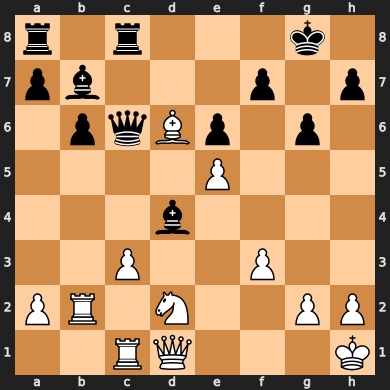

In [2]:
board = Board("r1r3k1/pb3p1p/1pqBp1p1/4P3/3b4/2P2P2/PR1N2PP/2RQ3K w - -")
pyBoard = PyBoard(board.fen())
pyBoard


In [4]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 800, 0, True)
debug_search(board, root, 0, 10, (10, 3))


  +---+---+---+---+---+---+---+---+
  | r |   | r |   |   |   | k |   | 8
  +---+---+---+---+---+---+---+---+
  | p | b |   |   |   | p |   | p | 7
  +---+---+---+---+---+---+---+---+
  |   | p | q | B | p |   | p |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | P |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   |   | b |   |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  |   |   | P |   |   | P |   |   | 3
  +---+---+---+---+---+---+---+---+
  | P | R |   | N |   |   | P | P | 2
  +---+---+---+---+---+---+---+---+
  |   |   | R | Q |   |   |   | K | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: r1r3k1/pb3p1p/1pqBp1p1/4P3/3b4/2P2P2/PR1N2PP/2RQ3K w - - 0 1
Key: e0ad08b08ad21983
Elapsed time: 0.11s
Total visits: 800
-------------------------------------------------------------------------------------
Move  | N      |   P. Norm  |  V [0, 1]    |  Q           |  U           |  Q+U        
------------------------------------

In [5]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 100_000, 0, True)
debug_search(board, root, 0, 10, (10, 3))


  +---+---+---+---+---+---+---+---+
  | r |   | r |   |   |   | k |   | 8
  +---+---+---+---+---+---+---+---+
  | p | b |   |   |   | p |   | p | 7
  +---+---+---+---+---+---+---+---+
  |   | p | q | B | p |   | p |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | P |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   |   | b |   |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  |   |   | P |   |   | P |   |   | 3
  +---+---+---+---+---+---+---+---+
  | P | R |   | N |   |   | P | P | 2
  +---+---+---+---+---+---+---+---+
  |   |   | R | Q |   |   |   | K | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: r1r3k1/pb3p1p/1pqBp1p1/4P3/3b4/2P2P2/PR1N2PP/2RQ3K w - - 0 1
Key: e0ad08b08ad21983
Elapsed time: 12.41s
Total visits: 100000
-------------------------------------------------------------------------------------
Move  | N      |   P. Norm  |  V [0, 1]    |  Q           |  U           |  Q+U        
--------------------------------

In [6]:
del trt_func, model
trt_func, model = load_as_trt_model("latest")

2025-07-18 15:03:39.631654: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [7]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 800, 0, True)
debug_search(board, root, 0, 10, (10, 3))


  +---+---+---+---+---+---+---+---+
  | r |   | r |   |   |   | k |   | 8
  +---+---+---+---+---+---+---+---+
  | p | b |   |   |   | p |   | p | 7
  +---+---+---+---+---+---+---+---+
  |   | p | q | B | p |   | p |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | P |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   |   | b |   |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  |   |   | P |   |   | P |   |   | 3
  +---+---+---+---+---+---+---+---+
  | P | R |   | N |   |   | P | P | 2
  +---+---+---+---+---+---+---+---+
  |   |   | R | Q |   |   |   | K | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: r1r3k1/pb3p1p/1pqBp1p1/4P3/3b4/2P2P2/PR1N2PP/2RQ3K w - - 0 1
Key: e0ad08b08ad21983
Elapsed time: 0.07s
Total visits: 800
-------------------------------------------------------------------------------------
Move  | N      |   P. Norm  |  V [0, 1]    |  Q           |  U           |  Q+U        
------------------------------------

In [8]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 100_000, 0, True)
debug_search(board, root, 0, 10, (10, 3))


  +---+---+---+---+---+---+---+---+
  | r |   | r |   |   |   | k |   | 8
  +---+---+---+---+---+---+---+---+
  | p | b |   |   |   | p |   | p | 7
  +---+---+---+---+---+---+---+---+
  |   | p | q | B | p |   | p |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   | P |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   |   | b |   |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  |   |   | P |   |   | P |   |   | 3
  +---+---+---+---+---+---+---+---+
  | P | R |   | N |   |   | P | P | 2
  +---+---+---+---+---+---+---+---+
  |   |   | R | Q |   |   |   | K | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: r1r3k1/pb3p1p/1pqBp1p1/4P3/3b4/2P2P2/PR1N2PP/2RQ3K w - - 0 1
Key: e0ad08b08ad21983
Elapsed time: 13.65s
Total visits: 100000
-------------------------------------------------------------------------------------
Move  | N      |   P. Norm  |  V [0, 1]    |  Q           |  U           |  Q+U        
--------------------------------

In [18]:
# results1
# [('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
#  ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
#  ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
#  ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
#  ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
#  ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
#  ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
#  ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
#  ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56)]

In [19]:
# results2
# performance_results2 = [
#     ("RustChess", "Python", "TRT", "FP32", 1, 686.1),
#     ("RustChess", "Cython", "TRT", "FP32", 1, 816.1),
#     ("RustChess", "Python", "TRT", "FP16", 1, 835.0),
#     ("RustChess", "Cython", "TRT", "FP16", 1, 1032.7),
#     ("RustChess", "Python", "TRT", "FP32", 16, 2692.9),
#     ("RustChess", "Cython", "TRT", "FP32", 16, 7791.9),
#     ("RustChess", "Python", "TRT", "FP16", 16, 2913.8),
#     ("RustChess", "Cython", "TRT", "FP16", 16, 9414.3),
#     ("RustChess", "Python", "TRT", "FP32", 32, 2925.5),
#     ("RustChess", "Cython", "TRT", "FP32", 32, 9055.2),
#     ("RustChess", "Python", "TRT", "FP16", 32, 3211.5),
#     ("RustChess", "Cython", "TRT", "FP16", 32, 13914.4),
# ]
# performance_results2

In [20]:
# results_combined = [
#  ('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
#  ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
#  ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
#  ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
#  ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
#  ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
#  ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
#  ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
#  ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56),
#  ('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
#  ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
#  ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
#  ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
#  ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
#  ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
#  ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
#  ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
#  ('RustChess', 'Python', 'TRT', 'FP32', 32, 2925.5),
#  ('RustChess', 'Cython', 'TRT', 'FP32', 32, 9055.2),
#  ('RustChess', 'Python', 'TRT', 'FP16', 32, 3211.5),
#  ('RustChess', 'Cython', 'TRT', 'FP16', 32, 13914.4)]
# results_combined